# Examples of all decoders (except Kalman Filter)

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data for use in all decoders
4. Run all decoders and print the goodness of fit
5. Plot example decoded outputs

See "Examples_kf_decoder" for a Kalman filter example. <br>
Because the Kalman filter utilizes different preprocessing, we don't include an example here. to keep this notebook more understandable

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [176]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import WienerCascadeDecoder
from decoders import WienerFilterDecoder
from decoders import DenseNNDecoder
from decoders import SimpleRNNDecoder
from decoders import GRUDecoder
from decoders import LSTMDecoder
from decoders import XGBoostDecoder

## 2. Load Data

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [177]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
# folder='/Users/jig289/Dropbox/Grad_School/Research/Projects/In_Progress/Decoding/DataFiles/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'hc_test_data.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f)

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [178]:
bins_before=4 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=5 #How many bins of neural data after (and including) the output are used for decoding

### 3B. Format Covariates

#### Format Input Covariates

In [179]:
#Remove neurons with too few spikes
nd_sum=np.nansum(neural_data,axis=0)
rmv_nrn=np.where(nd_sum<200)
# rmv_nrn=np.where(nd_sum<100)
neural_data=np.delete(neural_data,rmv_nrn,1)

# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#### Format Output Covariates

In [180]:
#Set decoding output
y=pos_binned

### 3C. Process Covariates
We normalize (z_score) the inputs and zero-center the outputs.

In [181]:
#Z-scoring function that works with Nans:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [182]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)

#Zero-center outputs
y_mean=np.nanmean(y,axis=0)
y=y-y_mean

In [183]:
#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
X_flat=np.delete(X_flat,rmv_time,0)
y=np.delete(y,rmv_time,0)

### 3D. Split into training and testing sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

#### User Options

In [184]:
def get_mR2(y_test,y_test_pred):
    y_mean=np.mean(y_test,axis=0)
    R2=1-np.sum(np.sum((y_test_pred-y_test)**2,axis=0))/np.sum(np.sum((y_test-y_mean)**2,axis=0))
    return R2

In [189]:
#Set what part of data should be part of the training/testing/validation sets

# training_range=[0.1, 0.5]
# testing_range=[0.5, 1]
# valid_range=[0,.1]

# training_range=[0, 0.32]
# testing_range=[0.5, 1]
# valid_range=[0.32,.4]

training_range=[0.08, .4]
testing_range=[0.5, 1]
valid_range=[0,.08]

#### Split Data

In [190]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

## 4. Run Decoders
Note that in this example, we are evaluating the model fit on the validation set

### 4A. Wiener Filter (Linear Regression)

In [172]:
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)

#Get metric of fit
R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
print('R2s:', R2s_wf)

('R2s:', array([ 0.17515508,  0.35694829]))


### 4B. Wiener Cascade (Linear Nonlinear Model)

In [194]:
#Declare model
model_wc=WienerCascadeDecoder(degree=5)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

('R2s:', array([ 0.19667799,  0.39743029]))


In [ ]:
2: 0.22289507,  0.39708868 ***
3: 0.20652599,  0.4022238
4: 0.20925797,  0.40430202   
5: 0.19667799,  0.39743029

### 4C. XGBoost (Extreme Gradient Boosting)

In [268]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=5,num_round=200)

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

('R2s:', array([ 0.34999756,  0.52373705]))


In [ ]:
3/200: 
5/200: 0.34999756,  0.52373705

4/200: 0.36401246,  0.52668198 ***
4/400: 0.35602212,  0.51585867
4/600: 0.3479263 ,  0.50571481

3/200: 0.34954087,  0.52451669    
3/400: 0.34863851,  0.51628159
3/600: 0.34343683,  0.51088184
    
2/400: 0.33914666,  0.5085746

2/600: 
2/1000: 
    
1/400: 

### 4D. Dense Neural Network

In [21]:
#Declare model
model_dnn=DenseNNDecoder(units=[600,600],dropout=0,num_epochs=20)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

('R2s:', array([ 0.36153866,  0.58421485]))


In [ ]:
1 layer:
400/0/5: 
400/0/10: 
400/.25/10: 

600/0/10: 
800/0/10: 

2 layers:
400/0/5: 
400/0/10: 0.30564009,  0.54719519
400/0/15: 0.37669348,  0.54151638
400/0/20:    

400/.25/10: 0.30719808,  0.55175272       
400/.25/15: 0.40464483,  0.55878283 ***
400/.25/20: 0.37391638,  0.53270319
    
600/0/15: 0.41797842,  0.54107495
600/0/20: 0.36153866,  0.58421485
600/.25/10: 0.34065195,  0.57358104
600/.25/15: 0.36941889,  0.56564866
600/.25/20: 0.36100262,  0.54387916


### 4E. Simple RNN

In [175]:
#Declare model
model_rnn=SimpleRNNDecoder(units=400,dropout=.25,num_epochs=15)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

('R2s:', array([ 0.26258515,  0.50124422]))


In [ ]:
400/0/5: 0.33162778,  0.51038918
400/0/10: 0.39120366,  0.4909212

400/.25/5: 0.26182809,  0.49396034
400/.25/10: 0.34338727,  0.52297347 
400/.25/15: 0.32974823,  0.54007528 ****
400/.25/20: 0.32399651,  0.52219084
    
200/0/5: 
200/0/10: 
    
600/0/5: 0.28606744,  0.52951992
600/.25/10: 0.32392509,  0.53798519

### 4F. GRU (Gated Recurrent Unit)

In [204]:
#Declare model
model_gru=GRUDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

('R2s:', array([ 0.4159255 ,  0.59208724]))


In [ ]:
400/0/5: 0.4159255 ,  0.59208724
400/0/10: 0.35214489,  0.51638594
400/.25/5: 
400/.25/10: 0.27703923,  0.50017441
400/.25/15: 
    
600/.25/10:

### 4G. LSTM (Long Short Term Memory)

In [201]:
#Declare model
model_lstm=LSTMDecoder(units=200,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

('R2s:', array([ 0.25696404,  0.56311165]))


In [ ]:
400/0/5: 0.4004935 ,  0.56693014 ***
400/0/10: 0.32846618,  0.52093606
400/.25/5: 0.28969395,  0.47484987
400/.25/10: 0.30589643,  0.54383976
400/.25/15: 0.22442909,  0.47230871
    
600/0/5: 0.33572567,  0.48828407
200/0/5: 0.25696404,  0.56311165

## 5. Make Plots

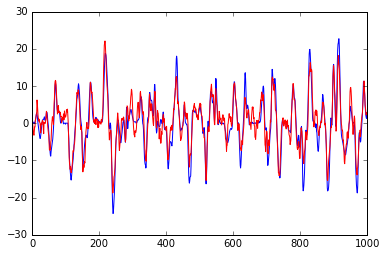

In [17]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure()
plt.plot(y_valid[1000:2000,0]+y_mean[0],'b')
plt.plot(y_valid_pred_lin[1000:2000,0]+y_mean[0],'r')

#Save figure
# fig_x_lin.savefig('x_velocity_decoding.eps')

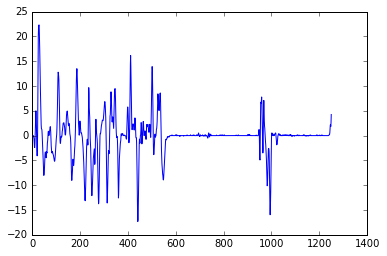

In [37]:
plt.plot(y_valid[:,0]+y_mean[0],'b')


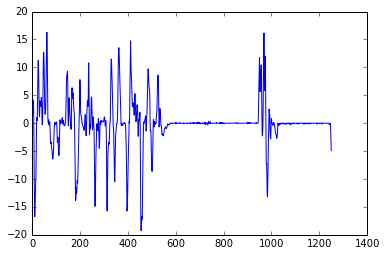

In [36]:
plt.plot(y_valid[:,1]+y_mean[1],'b')


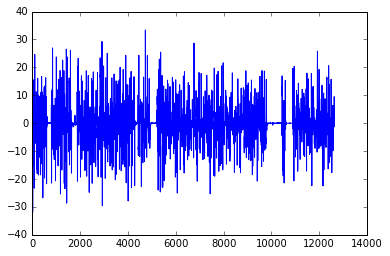

In [38]:
plt.plot(y_train[:,1]+y_mean[1],'b')
